In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer

import torch
#from sentence_transformers import SentenceTransformer, InputExample, losses, models, evaluation
from torch.utils.data import DataLoader
#from sentence_transformers import LoggingHandler
#from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
import logging
import numpy as np
import re

#from sklearn.metrics import roc_curve, auc

from tqdm.auto import tqdm
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import roc_curve, auc


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_folder = "C:\\Users\\gckc1\\My Drive\\My programs\\Sierra\\full_auto_review_data\\20240115_for_model_training"
model_folder = "C:\\Users\\gckc1\\My Drive\\My programs\\Sierra\\model_training"
review_data_folder = "C:\\Users\\gckc1\\My Drive\\My programs\\Sierra\\review_list"


In [5]:
val_file_location = "20240417_val_set.csv"
val_file = pd.read_csv(data_folder + "\\" + val_file_location)

dev_file_location = "20240417_dev_set_shuffled.csv"
dev_file = pd.read_csv(data_folder + "\\" + dev_file_location)

val_heart_file_location = "20240417_val_heart_set.csv"
val_heart_file = pd.read_csv(data_folder + "\\" + val_heart_file_location) 

val_HIV_file_location = "20240417_val_HIV_set.csv"
val_HIV_file = pd.read_csv(data_folder + "\\" + val_HIV_file_location) 

In [3]:
recode_dict = {0:0, 0.6:0.5, 1:1}
dev_file["label"] = dev_file["label"].replace(recode_dict)
val_file["label"] = val_file["label"].replace(recode_dict)
val_heart_file["label"] = val_heart_file["label"].replace(recode_dict)
val_HIV_file["label"] = val_HIV_file["label"].replace(recode_dict)



In [4]:
dev_file["obj_sel"] = dev_file["obj_sel"].str.replace(r'^\[OA\]', '', regex=True)
dev_file["tit_abs"] = dev_file["tit_abs"].str.replace(r'^ \[OA\]', '', regex=True)

val_file["obj_sel"] = val_file["obj_sel"].str.replace(r'^\[OA\]', '', regex=True)
val_file["tit_abs"] = val_file["tit_abs"].str.replace(r'^ \[OA\]', '', regex=True)

val_heart_file["obj_sel"] = val_heart_file["obj_sel"].str.replace(r'^\[OA\]', '', regex=True)
val_heart_file["tit_abs"] = val_heart_file["tit_abs"].str.replace(r'^ \[OA\]', '', regex=True)

val_HIV_file["obj_sel"] = val_HIV_file["obj_sel"].str.replace(r'^\[OA\]', '', regex=True)
val_HIV_file["tit_abs"] = val_HIV_file["tit_abs"].str.replace(r'^ \[OA\]', '', regex=True)

dev_file["obj_sel"] = dev_file["obj_sel"].str.replace(r'^\[BG\]', ' [BG] ', regex=True)
val_file["obj_sel"] = val_file["obj_sel"].str.replace(r'^\[BG\]', ' [BG] ', regex=True)
val_heart_file["obj_sel"] = val_heart_file["obj_sel"].str.replace(r'^\[BG\]', ' [BG] ', regex=True)
val_HIV_file["obj_sel"] = val_HIV_file["obj_sel"].str.replace(r'^\[BG\]', ' [BG] ', regex=True)

In [7]:
val_file["obj_sel"][0]

'[RTI] Abdominal decompression for suspected fetal compromise/pre‐eclampsia [BG] Abdominal decompression was developed as a means of pain relief during labour. It has also been used for complications of pregnancy, and in healthy pregnant women in an attempt to improve fetal wellbeing and intellectual development. [OBJ] The objective of this review was to assess the effects of antenatal abdominal decompression for maternal hypertension or impaired fetal growth, on perinatal outcome. [SEL] Randomised or quasi‐randomised trials comparing abdominal decompression with no decompression in women with pre‐eclampsia and/or fetuses thought to be compromised.'

In [6]:
dev_file["obj_sel"] = "[RTI] " + dev_file["Review_Title"] + dev_file["obj_sel"]
val_file["obj_sel"] = "[RTI] " + val_file["Review_Title"] + val_file["obj_sel"]
val_heart_file["obj_sel"] = "[RTI] " + val_heart_file["Review_Title"] + val_heart_file["obj_sel"]
val_HIV_file["obj_sel"] = "[RTI] " + val_HIV_file["Review_Title"] + val_HIV_file["obj_sel"]

In [8]:
dev_file_1 = dev_file[0:100000].copy()
dev_file_2 = dev_file[100000:200000].copy()
dev_file_3 = dev_file[200000:300000].copy()
dev_file_4 = dev_file[300000:466975].copy()
#val_file = val_file.sample(10000).copy()
#val_file = val_file.sample(5000).copy()

In [9]:
val_HIV_set = Dataset.from_pandas(val_HIV_file)
val_set = Dataset.from_pandas(val_file)
dev_set_1 = Dataset.from_pandas(dev_file_1)
dev_set_2 = Dataset.from_pandas(dev_file_2)
dev_set_3 = Dataset.from_pandas(dev_file_3)
dev_set_4 = Dataset.from_pandas(dev_file_4)
val_heart_set = Dataset.from_pandas(val_heart_file)

In [2]:
model_ckpt = "dmis-lab/biobert-large-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

In [3]:
new_tokens = ["[RIT]", "[OBJ]", "[BG]", "[SEL]", "[TIT]", "[ABS]"]
num_added_toks = tokenizer.add_tokens(new_tokens)

In [4]:
# Check if the new tokens are in the tokenizer
for token in new_tokens:
    if token in tokenizer.get_vocab():
        print(f"Token {token} is in the vocabulary.")
    else:
        print(f"Token {token} is not in the vocabulary.")

# Check the size of the new embeddings
print(f"New embedding size: {model.get_input_embeddings().num_embeddings}")

model.resize_token_embeddings(len(tokenizer))

Token [RIT] is in the vocabulary.
Token [OBJ] is in the vocabulary.
Token [BG] is in the vocabulary.
Token [SEL] is in the vocabulary.
Token [TIT] is in the vocabulary.
Token [ABS] is in the vocabulary.
New embedding size: 58996


Embedding(59002, 1024)

In [45]:
def token(df_input):
    df = Dataset.from_pandas(df_input.copy())
    for part in ["obj_sel", "tit_abs"]:
        df = df.map(
            lambda x:  tokenizer(
                x[part], max_length = 512, padding = True, truncation = True
            ), batched = True, batch_size = None
        )
        for col in ['input_ids', 'attention_mask']:
            df = df.rename_column(
                col, part+"_"+col
            )
    return(df)

In [14]:
val_HIV_set = token(val_HIV_file)
val_set = token(val_file)
dev_set_1 = token(dev_file_1)
dev_set_2 = token(dev_file_2)
dev_set_3 = token(dev_file_3)
dev_set_4 = token(dev_file_4)
val_heart_set = token(val_heart_file)

Map:   0%|          | 0/4400 [00:00<?, ? examples/s]

Map:   0%|          | 0/4400 [00:00<?, ? examples/s]

Map:   0%|          | 0/53943 [00:00<?, ? examples/s]

Map:   0%|          | 0/53943 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Map:   0%|          | 0/166975 [00:00<?, ? examples/s]

Map:   0%|          | 0/166975 [00:00<?, ? examples/s]

Map:   0%|          | 0/18839 [00:00<?, ? examples/s]

Map:   0%|          | 0/18839 [00:00<?, ? examples/s]

In [15]:
all_cols = ['label', 'obj_sel_input_ids', 'obj_sel_attention_mask', 'tit_abs_input_ids', 'tit_abs_attention_mask']


In [16]:
tmp1 = dev_set_1.to_pandas()
tmp2 = dev_set_2.to_pandas()
tmp3 = dev_set_3.to_pandas()
tmp4 = dev_set_4.to_pandas()

tmp = pd.concat([tmp1, tmp2, tmp3, tmp4], ignore_index = True)

dev_set = Dataset.from_pandas(tmp)

In [17]:
dev_set.set_format(type = 'torch', columns = all_cols)
val_set.set_format(type = 'torch', columns = all_cols)

In [18]:
batch_size = 32
loader = torch.utils.data.DataLoader(
    dev_set, batch_size=batch_size, shuffle = True)

In [5]:
def mean_pool(token_embeds, attention_mask):
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(
        in_mask.sum(1), min=1e-9
    )
    return pool
    

In [20]:
ffnn = torch.nn.Linear(1024*3, 1)

In [21]:
loss_func = torch.nn.MSELoss()

In [22]:
from transformers.optimization import get_linear_schedule_with_warmup

optim = torch.optim.Adam(model.parameters(), lr = 2e-5)
total_steps = int(len(dev_set) / batch_size)
warmup_steps = 500
scheduler = get_linear_schedule_with_warmup(
    optim, num_warmup_steps=warmup_steps,
    num_training_steps=total_steps - warmup_steps
)




In [23]:
import torch.nn as nn

model = nn.DataParallel(model)
ffnn = nn.DataParallel(ffnn)

In [24]:
model = model.to(device)
ffnn = ffnn.to(device)

In [25]:
for epoch in range(1):
    model.train()
    loop = tqdm(loader, leave= True)
    for batch in loop:
        optim.zero_grad()
        inputs_ids_a = batch['obj_sel_input_ids'].to(device)
        inputs_ids_b = batch['tit_abs_input_ids'].to(device)
        attention_a = batch['obj_sel_attention_mask'].to(device)
        attention_b = batch['tit_abs_attention_mask'].to(device)
        label = batch['label'].to(device)
        u = model(inputs_ids_a, attention_mask = attention_a)[0]
        v = model(inputs_ids_b, attention_mask = attention_b)[0]
        u = mean_pool(u, attention_a)
        v = mean_pool(v, attention_b)
        uv = torch.sub(u, v)
        uv_abs = torch.abs(uv)
        x = torch.cat([u, v, uv_abs], dim = -1)
        x = ffnn(x)
        x = x.squeeze()
        loss = loss_func(x, label)
        loss.backward()
        optim.step()
        scheduler.step()
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

  0%|          | 0/14593 [00:00<?, ?it/s]

C:\Users\gckc1\anaconda3\envs\Sierra\Lib\site-packages\torch\cuda\nccl.py:15: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn("PyTorch is not compiled with NCCL support")


In [26]:
torch.save(model, model_folder + "\\20240417_biobert_relevance_title_bg\\" + '20240417_biobert_relevance.pth')
torch.save(ffnn, model_folder + "\\20240417_biobert_relevance_title_bg\\" + '20240417_ffnn_relevance.pth')

In [ ]:
####################################################################

In [6]:
val_1_file_location = "20240419_val_1_rti_bg_obj_sel_output.csv"
val_1_file = pd.read_csv(data_folder + "\\" + val_1_file_location)

val_2_file_location = "20240419_val_2_rti_bg_obj_sel_output.csv"
val_2_file = pd.read_csv(data_folder + "\\" + val_2_file_location)

val_heart_file_location = "20240419_val_heart_rti_bg_obj_sel_output.csv"
val_heart_file = pd.read_csv(data_folder + "\\" + val_heart_file_location) 

val_HIV_file_location = "20240419_val_HIV_rti_bg_obj_sel_output.csv"
val_HIV_file = pd.read_csv(data_folder + "\\" + val_HIV_file_location) 

In [7]:
val_HIV_file = val_HIV_file.drop(['obj_sel_input_ids', 'token_type_ids', "obj_sel_attention_mask", "tit_abs_input_ids","tit_abs_attention_mask"], axis=1).copy()
val_heart_file = val_heart_file.drop(['obj_sel_input_ids', 'token_type_ids', "obj_sel_attention_mask", "tit_abs_input_ids","tit_abs_attention_mask"], axis=1).copy()
val_1_file = val_1_file.drop(['obj_sel_input_ids', 'token_type_ids', "obj_sel_attention_mask", "tit_abs_input_ids","tit_abs_attention_mask"], axis=1).copy()
val_2_file = val_2_file.drop(['obj_sel_input_ids', 'token_type_ids', "obj_sel_attention_mask", "tit_abs_input_ids","tit_abs_attention_mask"], axis=1).copy()

In [8]:
val_heart_additional = pd.read_csv(data_folder + "\\" + "20240504_val_heart_set_additional.csv")

In [9]:
val_heart_file = val_heart_file[['Review_URL', 'Objective', 'Selection_criteria',
       'Title', 'Abstract_clean', 'label', 'obj_sel', 'tit_abs', 'Background','Review_Title']].copy()

In [10]:
val_heart_additional = val_heart_additional[['Review_URL', 'Objective', 'Selection_criteria',
       'Title', 'Abstract_clean', 'label', 'obj_sel', 'tit_abs', 'Background','Review_Title']].copy()

In [11]:
val_heart_additional["obj_sel"] = "[RTI] " + val_heart_additional["Review_Title"] + " [BG] " + val_heart_additional["Background"].fillna("") + " [OBJ] " + val_heart_additional["Objective"].fillna("") + " [SEL] " + val_heart_additional["Selection_criteria"].fillna("")

In [12]:
val_1_file["obj_sel"] = "[RTI] " + val_1_file["Review_Title"] + " [BG] " + val_1_file["Background"].fillna("") + " [OBJ] " + val_1_file["Objective"].fillna("") + " [SEL] " + val_1_file["Selection_criteria"].fillna("")
val_2_file["obj_sel"] = "[RTI] " + val_2_file["Review_Title"] + " [BG] " + val_2_file["Background"].fillna("") + " [OBJ] " + val_2_file["Objective"].fillna("") + " [SEL] " + val_2_file["Selection_criteria"].fillna("")
val_heart_file["obj_sel"] = "[RTI] " + val_heart_file["Review_Title"] + " [BG] " + val_heart_file["Background"].fillna("") + " [OBJ] " + val_heart_file["Objective"].fillna("") + " [SEL] " + val_heart_file["Selection_criteria"].fillna("")
val_HIV_file["obj_sel"] = "[RTI] " + val_HIV_file["Review_Title"] + " [BG] " + val_HIV_file["Background"].fillna("") + " [OBJ] " + val_HIV_file["Objective"].fillna("") + " [SEL] " + val_HIV_file["Selection_criteria"].fillna("")

In [13]:
print(len(val_heart_file))
print(len(val_heart_additional))

18839
230


In [15]:
val_heart_file = pd.concat([val_heart_file, val_heart_additional], ignore_index = True)

In [16]:
print(len(val_heart_file))

19069


In [17]:
val_1_set = Dataset.from_pandas(val_1_file)
val_2_set = Dataset.from_pandas(val_2_file)
val_heart_set = Dataset.from_pandas(val_heart_file)
val_HIV_set = Dataset.from_pandas(val_HIV_file)

In [18]:
def token(df_input):
    df = Dataset.from_pandas(df_input.copy())
    for part in ["obj_sel", "tit_abs"]:
        df = df.map(
            lambda x:  tokenizer(
                x[part], max_length = 512, padding = True, truncation = True
            ), batched = True, batch_size = None
        )
        for col in ['input_ids', 'attention_mask']:
            df = df.rename_column(
                col, part+"_"+col
            )
    return(df)

In [19]:
val_heart_set = token(val_heart_file)
val_HIV_set = token(val_HIV_file)
val_1_set = token(val_1_file)
val_2_set = token(val_2_file)

Map:   0%|          | 0/19069 [00:00<?, ? examples/s]

Map:   0%|          | 0/19069 [00:00<?, ? examples/s]

Map:   0%|          | 0/4400 [00:00<?, ? examples/s]

Map:   0%|          | 0/4400 [00:00<?, ? examples/s]

Map:   0%|          | 0/26892 [00:00<?, ? examples/s]

Map:   0%|          | 0/26892 [00:00<?, ? examples/s]

Map:   0%|          | 0/27051 [00:00<?, ? examples/s]

Map:   0%|          | 0/27051 [00:00<?, ? examples/s]

In [20]:
all_cols = ['label', 'obj_sel_input_ids', 'obj_sel_attention_mask', 'tit_abs_input_ids', 'tit_abs_attention_mask']

In [21]:
val_1_set.set_format(type = 'torch', columns = all_cols)
val_2_set.set_format(type = 'torch', columns = all_cols)
val_heart_set.set_format(type = 'torch', columns = all_cols)
val_HIV_set.set_format(type = 'torch', columns = all_cols)

In [22]:
model = torch.load(model_folder + "\\20240417_biobert_relevance_title_bg\\" + '20240417_biobert_relevance.pth')
ffnn = torch.load(model_folder + "\\20240417_biobert_relevance_title_bg\\" + '20240417_ffnn_relevance.pth')

model = model.to(device)
ffnn = ffnn.to(device)

In [23]:
from torch.utils.data import DataLoader
val_1_loader = DataLoader(val_1_set, batch_size = 64, shuffle = False)
val_2_loader = DataLoader(val_2_set, batch_size = 64, shuffle = False)
val_heart_loader = DataLoader(val_heart_set, batch_size = 64, shuffle = False)
val_HIV_loader = DataLoader(val_HIV_set, batch_size = 64, shuffle = False)

In [24]:
def evaluate_model(model, ffnn, data_loader, device):
    model.eval()
    ffnn.eval()
    all_outputs = []
    predictions = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", leave = True):
            inputs_ids_a = batch['obj_sel_input_ids'].to(device)
            inputs_ids_b = batch['tit_abs_input_ids'].to(device)
            attention_a = batch['obj_sel_attention_mask'].to(device)
            attention_b = batch['tit_abs_attention_mask'].to(device)
            labels = batch['label'].to(device)

            u = model(inputs_ids_a, attention_mask = attention_a)[0]
            v = model(inputs_ids_b, attention_mask = attention_b)[0]
            u = mean_pool(u, attention_a)
            v = mean_pool(v, attention_b)
            uv = torch.sub(u, v)
            uv_abs = torch.abs(uv)
            outputs = torch.cat([u, v, uv_abs], dim= -1)
            outputs = ffnn(outputs)
            
            all_labels.extend(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())
    all_outputs = np.vstack(all_outputs)
    return all_labels, all_outputs

In [25]:
val_heart_labels, val_heart_outputs = evaluate_model(model, ffnn, val_heart_loader, device)
val_heart_outputs = val_heart_outputs.squeeze()

Evaluating:   0%|          | 0/298 [00:00<?, ?it/s]

In [26]:
val_1_labels, val_1_outputs = evaluate_model(model, ffnn, val_1_loader, device)
val_2_labels, val_2_outputs = evaluate_model(model, ffnn, val_2_loader, device)

val_HIV_labels, val_HIV_outputs = evaluate_model(model, ffnn, val_HIV_loader, device)


Evaluating:   0%|          | 0/421 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/423 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/69 [00:00<?, ?it/s]

In [27]:
val_1_outputs = val_1_outputs.squeeze()
val_2_outputs = val_2_outputs.squeeze()
val_HIV_outputs = val_HIV_outputs.squeeze()

In [28]:
def summary_stats(labels, outputs):
    predictions_df = pd.DataFrame({
        'Outputs': outputs,
        'Actual Labels': labels
    })
    print(predictions_df["Actual Labels"].value_counts())
    grouped_stats = predictions_df.groupby("Actual Labels")["Outputs"].describe()
    print(grouped_stats)

In [29]:
summary_stats(val_1_labels, val_1_outputs)

Actual Labels
0.0    12425
0.5     9922
1.0     4545
Name: count, dtype: int64
                 count      mean       std       min       25%       50%  \
Actual Labels                                                              
0.0            12425.0  0.065196  0.155275 -0.176678 -0.019180  0.016671   
0.5             9922.0  0.527589  0.218224 -0.159220  0.394899  0.566736   
1.0             4545.0  0.737404  0.143718 -0.019539  0.654779  0.749799   

                    75%       max  
Actual Labels                      
0.0            0.073987  0.966113  
0.5            0.682339  1.082599  
1.0            0.835948  1.143566  


In [30]:
summary_stats(val_2_labels, val_2_outputs)

Actual Labels
0.0    13020
0.5     9448
1.0     4583
Name: count, dtype: int64
                 count      mean       std       min       25%       50%  \
Actual Labels                                                              
0.0            13020.0  0.076969  0.170574 -0.230453 -0.016373  0.020869   
0.5             9448.0  0.536438  0.209033 -0.158068  0.416911  0.570915   
1.0             4583.0  0.731174  0.147334  0.001739  0.643870  0.741005   

                    75%       max  
Actual Labels                      
0.0            0.087171  1.047239  
0.5            0.685462  1.010483  
1.0            0.832999  1.113363  


In [31]:
summary_stats(val_heart_labels, val_heart_outputs)

Actual Labels
0.5    9500
0.0    7063
1.0    2506
Name: count, dtype: int64
                count      mean       std       min       25%       50%  \
Actual Labels                                                             
0.0            7063.0  0.088811  0.166890 -0.302011 -0.005941  0.030300   
0.5            9500.0  0.515467  0.195144 -0.069821  0.427696  0.552932   
1.0            2506.0  0.693340  0.128449  0.085549  0.616934  0.705140   

                    75%       max  
Actual Labels                      
0.0            0.104380  1.014922  
0.5            0.649527  0.979660  
1.0            0.779150  1.095924  


In [32]:
summary_stats(val_HIV_labels, val_HIV_outputs)

Actual Labels
0.0    2330
0.5    1491
1.0     579
Name: count, dtype: int64
                count      mean       std       min       25%       50%  \
Actual Labels                                                             
0.0            2330.0  0.149549  0.214155 -0.169424 -0.001087  0.058112   
0.5            1491.0  0.447414  0.237472 -0.064069  0.268928  0.494970   
1.0             579.0  0.666351  0.161184  0.120728  0.582174  0.700798   

                    75%       max  
Actual Labels                      
0.0            0.239219  0.937969  
0.5            0.642124  0.949572  
1.0            0.781011  1.000726  


In [ ]:
################# Evaluation 20240416 #########################

In [33]:
val_1_pd = val_1_set.to_pandas()
val_2_pd = val_2_set.to_pandas()
val_heart_set_pd = val_heart_set.to_pandas()
val_HIV_set_pd = val_HIV_set.to_pandas()

In [38]:
#val_1_pd = val_1_pd.drop("Actual Labels", axis = 1)
#val_2_pd = val_2_pd.drop("Actual Labels", axis = 1)
#val_heart_set_pd = val_heart_set_pd.drop("Actual Labels", axis = 1)
#val_HIV_set_pd = val_HIV_set_pd.drop("Actual Labels", axis = 1)

#val_1_pd = val_1_pd.drop("Outputs", axis = 1)
#val_2_pd = val_2_pd.drop("Outputs", axis = 1)
#val_heart_set_pd = val_heart_set_pd.drop("Outputs", axis = 1)
#val_HIV_set_pd = val_HIV_set_pd.drop("Outputs", axis = 1)

In [39]:
def combine_outputs(df, labels, outputs):
    predictions_df = pd.DataFrame({
        'Outputs': outputs,
        'Actual Labels': labels
    })  
    combined = pd.concat([df, predictions_df], axis = 1)
    return combined.copy()

In [40]:
val_1_pd = combine_outputs(val_1_pd, val_1_labels, val_1_outputs)
val_2_pd = combine_outputs(val_2_pd, val_2_labels, val_2_outputs)
val_heart_set_pd = combine_outputs(val_heart_set_pd, val_heart_labels, val_heart_outputs)


In [54]:
#val_HIV_set_pd = val_HIV_set_pd[['Review_URL', 'Objective', 'Selection_criteria',
#       'Title', 'Abstract_clean', 'label', 'obj_sel', 'tit_abs', 'Background',
#       'Unnamed: 0', 'Review_Title', 'DOI',
#       'expertise', 'label_1', 'obj_sel_input_ids',
#       'token_type_ids', 'obj_sel_attention_mask', 'tit_abs_input_ids',
#       'tit_abs_attention_mask']].copy()

In [53]:
val_HIV_set_pd = combine_outputs(val_HIV_set_pd, val_HIV_labels, val_HIV_outputs)

In [41]:
#Only need to run it once#

val_1_pd['DOI'] = val_1_pd['Review_URL'].str.extract(r'(10\.\d{4,9}/[-._;()/:A-Z0-9]+)', flags=re.IGNORECASE)
val_1_pd['DOI'] = val_1_pd['DOI'].str.replace(r'/full$', '', regex=True)

val_2_pd['DOI'] = val_2_pd['Review_URL'].str.extract(r'(10\.\d{4,9}/[-._;()/:A-Z0-9]+)', flags=re.IGNORECASE)
val_2_pd['DOI'] = val_2_pd['DOI'].str.replace(r'/full$', '', regex=True)

#Only need to run it once#

val_heart_set_pd['DOI'] = val_heart_set_pd['Review_URL'].str.extract(r'(10\.\d{4,9}/[-._;()/:A-Z0-9]+)', flags=re.IGNORECASE)
val_heart_set_pd['DOI'] = val_heart_set_pd['DOI'].str.replace(r'/full$', '', regex=True)

val_HIV_set_pd['DOI'] = val_HIV_set_pd['Review_URL'].str.extract(r'(10\.\d{4,9}/[-._;()/:A-Z0-9]+)', flags=re.IGNORECASE)
val_HIV_set_pd['DOI'] = val_HIV_set_pd['DOI'].str.replace(r'/full$', '', regex=True)

In [42]:
review_record = pd.read_csv(review_data_folder + "\\" + "20231218_cochrane_review_expertise.csv")

In [43]:
val_1_pd["expertise"] = val_1_pd['DOI'].isin(review_record['DOI'])
val_2_pd["expertise"] = val_2_pd['DOI'].isin(review_record['DOI'])
val_heart_set_pd["expertise"] = val_heart_set_pd['DOI'].isin(review_record['DOI'])
val_HIV_set_pd["expertise"] = val_HIV_set_pd['DOI'].isin(review_record['DOI'])

In [56]:
val_1_pd.to_csv(data_folder + "\\" + "20240419_val_1_rti_bg_obj_sel_output.csv")
val_2_pd.to_csv(data_folder + "\\" + "20240419_val_2_rti_bg_obj_sel_output.csv")
val_heart_set_pd.to_csv(data_folder + "\\" + "20240419_val_heart_rti_bg_obj_sel_output.csv")
val_HIV_set_pd.to_csv(data_folder + "\\" + "20240419_val_HIV_rti_bg_obj_sel_output.csv")

In [55]:
print(val_1_pd.columns)
print(val_2_pd.columns)
print(val_heart_set_pd.columns)
print(val_HIV_set_pd.columns)


Index(['Unnamed: 0.7', 'Unnamed: 0.6', 'Unnamed: 0.5', 'Unnamed: 0.4',
       'Unnamed: 0.3', 'Review_URL', 'Objective', 'Selection_criteria',
       'Title', 'Abstract_clean', 'label', 'obj_sel', 'tit_abs', 'Background',
       'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'Review_Title', 'DOI',
       'expertise', 'label_1', 'obj_sel_input_ids', 'token_type_ids',
       'obj_sel_attention_mask', 'tit_abs_input_ids', 'tit_abs_attention_mask',
       'Outputs', 'Actual Labels'],
      dtype='object')
Index(['Unnamed: 0.7', 'Unnamed: 0.6', 'Unnamed: 0.5', 'Unnamed: 0.4',
       'Unnamed: 0.3', 'Review_URL', 'Objective', 'Selection_criteria',
       'Title', 'Abstract_clean', 'label', 'obj_sel', 'tit_abs', 'Background',
       'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'Review_Title', 'DOI',
       'expertise', 'label_1', 'obj_sel_input_ids', 'token_type_ids',
       'obj_sel_attention_mask', 'tit_abs_input_ids', 'tit_abs_attention_mask',
       'Outputs', 'Actual Labels'],
      dtyp

In [ ]:
# 20240428 Load evaluation data #

In [16]:
val_1_pd = pd.read_csv(data_folder + "\\" + "20240419_val_1_rti_bg_obj_sel_output.csv")
val_2_pd = pd.read_csv(data_folder + "\\" + "20240419_val_2_rti_bg_obj_sel_output.csv")
val_heart_set_pd = pd.read_csv(data_folder + "\\" + "20240419_val_heart_rti_bg_obj_sel_output.csv")
val_HIV_set_pd = pd.read_csv(data_folder + "\\" + "20240419_val_HIV_rti_bg_obj_sel_output.csv")

In [57]:
def roc_analysis(df, output_column, save = False):
    df["label_1"] = df["Actual Labels"].copy()
    df.loc[df['label_1'] < 0.7, 'label_1'] = 0
    fpr_1, tpr_1, tresholds_1 = roc_curve(df["label_1"], df[output_column])
    roc_auc_1 = auc(fpr_1, tpr_1)
    
    plt.figure()
    plt.plot(fpr_1, tpr_1, color = 'darkorange', lw = 2, label = "ROC curve (area = %0.2f)" % roc_auc_1)
    plt.plot([0,1],[0,1], color = 'navy', lw = 2, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    if save:
        roc_analysis_1 = pd.DataFrame({"False Positive Rate": fpr_1, "True Positive Rate":tpr_1, "Cut off":tresholds_1})
        roc_analysis_1 = roc_analysis_1.sort_values(by = "True Positive Rate", ascending = False)
        roc_analysis_1.to_csv(data_folder + "\\" + "tmp_results_1.csv")

******************************************
Val 1
******************************************


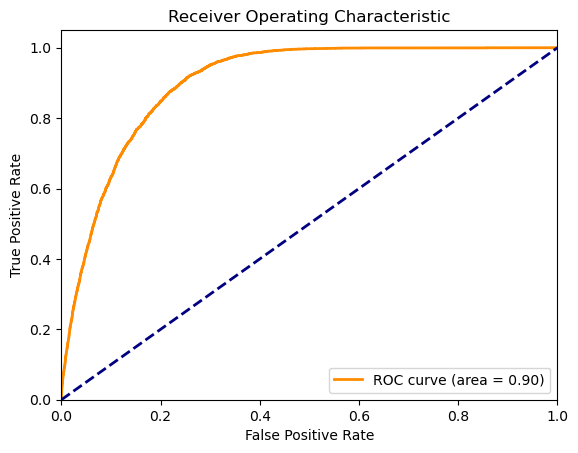

******************************************
Val 2
******************************************


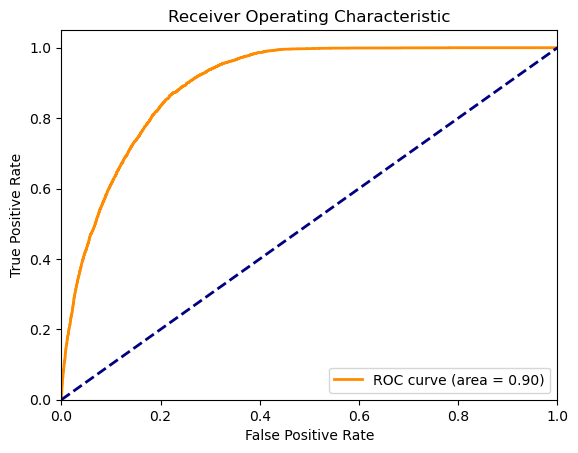

******************************************
Val Heart
******************************************


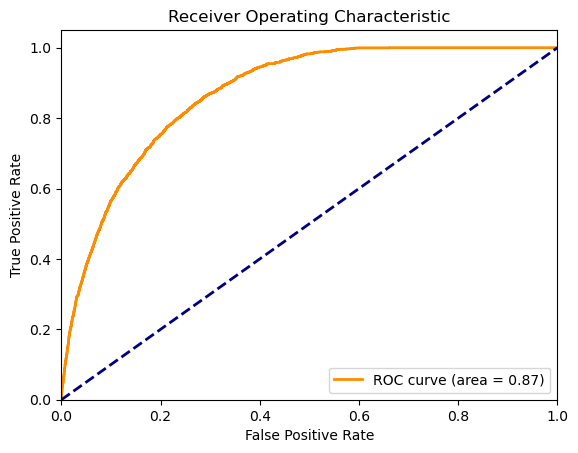

******************************************
Val HIV
******************************************


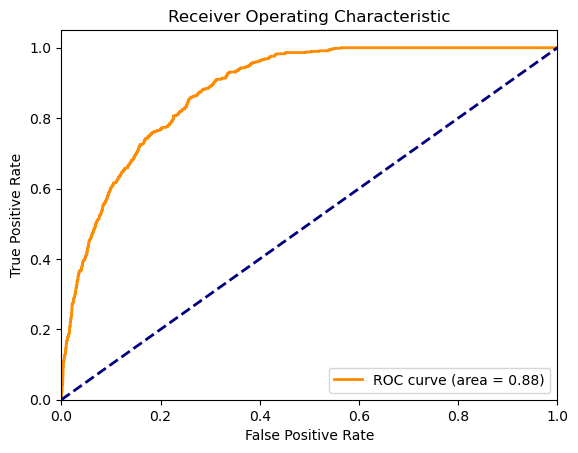

In [58]:
print("******************************************")
print("Val 1")
print("******************************************")
roc_analysis(val_1_pd, "Outputs", save = True)
print("******************************************")
print("Val 2")
print("******************************************")
roc_analysis(val_2_pd, "Outputs")
print("******************************************")
print("Val Heart")
print("******************************************")
roc_analysis(val_heart_set_pd, "Outputs")
print("******************************************")
print("Val HIV")
print("******************************************")
roc_analysis(val_HIV_set_pd, "Outputs")

In [60]:
def evaluate_cutoff(df, column, cutoff):
    df_tmp = df.copy()
    df_tmp["cutoff"] = (df_tmp[column] > cutoff)
    ct = pd.crosstab(df_tmp["Actual Labels"], df_tmp["cutoff"])
    
    print(ct)
    
    row_percentage = ct.div(ct.sum(axis = 1), axis = 0)
    
    print(row_percentage)
    return ct, row_percentage
    


In [ ]:
#2.5%: 0.423; 3% 0.442.

In [62]:
k = 0.423

In [21]:
evaluate_cutoff(val_1_pd, "Outputs", k)

cutoff         False  True 
Actual Labels              
0.0            11756    669
0.5             2760   7162
1.0              114   4431
cutoff            False     True 
Actual Labels                    
0.0            0.946157  0.053843
0.5            0.278170  0.721830
1.0            0.025083  0.974917


In [22]:
evaluate_cutoff(val_2_pd, "Outputs", k)

cutoff         False  True 
Actual Labels              
0.0            12166    854
0.5             2416   7032
1.0              158   4425
cutoff            False     True 
Actual Labels                    
0.0            0.934409  0.065591
0.5            0.255715  0.744285
1.0            0.034475  0.965525


In [63]:
evaluate_cutoff(val_heart_set_pd, "Outputs", k)

cutoff         False  True 
Actual Labels              
0.0             6583    480
0.5             2314   7186
1.0               78   2428
cutoff            False     True 
Actual Labels                    
0.0            0.932040  0.067960
0.5            0.243579  0.756421
1.0            0.031125  0.968875


(cutoff         False  True 
 Actual Labels              
 0.0             6583    480
 0.5             2314   7186
 1.0               78   2428,
 cutoff            False     True 
 Actual Labels                    
 0.0            0.932040  0.067960
 0.5            0.243579  0.756421
 1.0            0.031125  0.968875)

In [24]:
evaluate_cutoff(val_HIV_set_pd, "Outputs", k)

cutoff         False  True 
Actual Labels              
0.0             1993    337
0.5              608    883
1.0               52    527
cutoff            False     True 
Actual Labels                    
0.0            0.855365  0.144635
0.5            0.407780  0.592220
1.0            0.089810  0.910190


In [12]:
def calculate_norm(df_relevance, output_column):
    df_tmp = df_relevance.copy()
    groups = [df1 for _, df1 in df_tmp.groupby("Objective")]
    for i in range(0, len(groups)):
        maximum = groups[i][output_column].max()
        minimum = groups[i][output_column].min()
        groups[i]["Normed relevance"] = (groups[i][output_column] - minimum)/(maximum - minimum)
        p95 = groups[i][output_column].quantile(0.95)
        p90 = groups[i][output_column].quantile(0.90)
        groups[i]["Normed relevance 95"] = (groups[i][output_column] - minimum)/(p95 - minimum)
        groups[i].loc[groups[i]["Normed relevance 95"] > 1, 'Normed relevance 95'] = 1 
        groups[i]["Normed relevance 90"] = (groups[i][output_column] - minimum)/(p90 - minimum)
        groups[i].loc[groups[i]["Normed relevance 90"] > 1, 'Normed relevance 90'] = 1
    df_norm = pd.concat(groups, ignore_index = True)
    return df_norm.copy()
    

In [13]:
val_1_pd_n9095 = calculate_norm(val_1_pd, "Outputs")
val_2_pd_n9095 = calculate_norm(val_2_pd, "Outputs")
val_heart_pd_n9095 = calculate_norm(val_heart_set_pd, "Outputs")
val_HIV_pd_n9095 = calculate_norm(val_HIV_set_pd, "Outputs")

In [ ]:
len(val_heart_set_pd)

******************************************
Val 1
******************************************


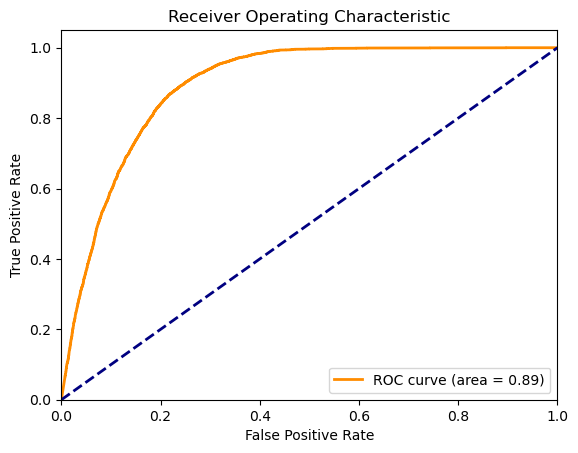

******************************************
Val 2
******************************************


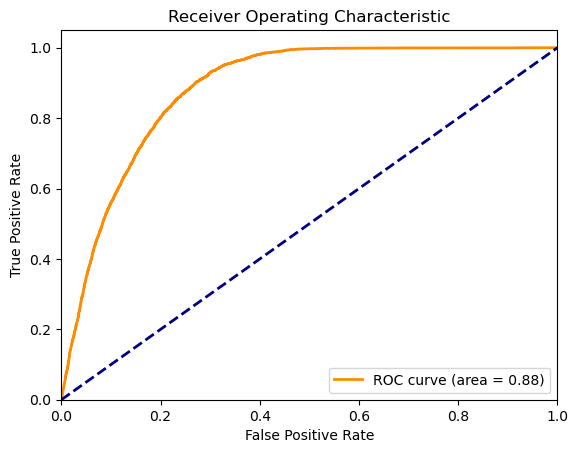

******************************************
Val Heart
******************************************


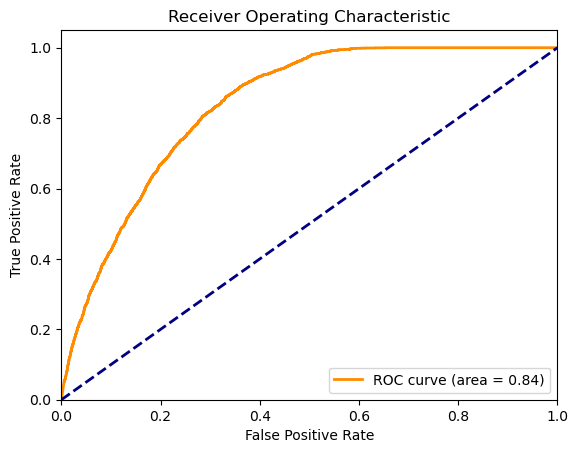

******************************************
Val HIV
******************************************


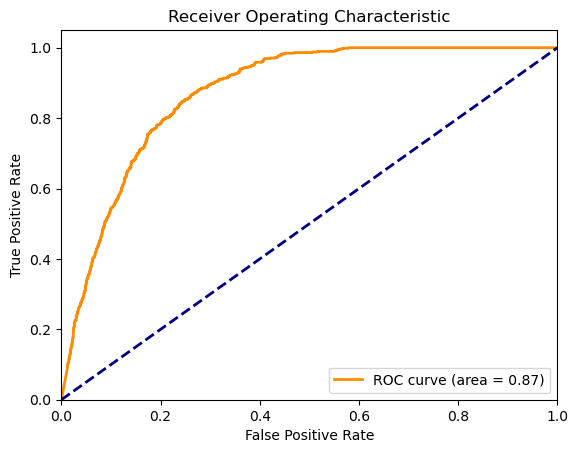

In [26]:
print("******************************************")
print("Val 1")
print("******************************************")
roc_analysis(val_1_pd_n9095, "Normed relevance", save = True)
print("******************************************")
print("Val 2")
print("******************************************")
roc_analysis(val_2_pd_n9095, "Normed relevance")
print("******************************************")
print("Val Heart")
print("******************************************")
roc_analysis(val_heart_pd_n9095, "Normed relevance")
print("******************************************")
print("Val HIV")
print("******************************************")
roc_analysis(val_HIV_pd_n9095, "Normed relevance")

In [31]:
evaluate_cutoff(val_1_pd_n9095, "Normed relevance", 0.528)

cutoff         False  True 
Actual Labels              
0.0            11473    952
0.5             2548   7374
1.0              114   4431
cutoff            False     True 
Actual Labels                    
0.0            0.923380  0.076620
0.5            0.256803  0.743197
1.0            0.025083  0.974917


In [32]:
evaluate_cutoff(val_2_pd_n9095, "Normed relevance", 0.528)

cutoff         False  True 
Actual Labels              
0.0            11949   1071
0.5             2124   7324
1.0              136   4447
cutoff            False     True 
Actual Labels                    
0.0            0.917742  0.082258
0.5            0.224809  0.775191
1.0            0.029675  0.970325


In [33]:
evaluate_cutoff(val_heart_pd_n9095, "Normed relevance", 0.528)

cutoff         False  True 
Actual Labels              
0.0             6375    599
0.5             1865   7564
1.0               63   2373
cutoff            False     True 
Actual Labels                    
0.0            0.914110  0.085890
0.5            0.197794  0.802206
1.0            0.025862  0.974138


In [34]:
evaluate_cutoff(val_HIV_pd_n9095, "Normed relevance", 0.528)

cutoff         False  True 
Actual Labels              
0.0             1938    392
0.5              511    980
1.0               40    539
cutoff            False     True 
Actual Labels                    
0.0            0.831760  0.168240
0.5            0.342723  0.657277
1.0            0.069085  0.930915


In [37]:
val_1_pd_n9095["Review_URL"][0]

'https://www.cochranelibrary.com/cdsr/doi/10.1002/14651858.CD008454.pub2/full'

In [66]:
master_review_list = pd.read_csv(review_data_folder + "\\processed\\" + "20240331_cochrane_review_list.csv")

In [50]:
val_1 = val_1_pd_n9095.merge(master_review_list[["Review_URL","Cochrane Review Group Code"]], on="Review_URL", how = "left")
val_2 = val_2_pd_n9095.merge(master_review_list[["Review_URL","Cochrane Review Group Code"]], on="Review_URL", how = "left")

In [51]:
val_1["Cochrane Review Group Code"].value_counts()

Cochrane Review Group Code
Airways                                              1926
Kidney and Transplant                                1532
Pain, Palliative and Supportive Care                 1364
Pregnancy and Childbirth                             1284
Neonatal                                             1220
Developmental, Psychosocial and Learning Problems    1081
Hepato-Biliary                                       1046
Infectious Diseases                                   792
Consumers and Communication                           768
Gynaecological, Neuro-oncology and Orphan Cancer      697
Gynaecology and Fertility                             664
Common Mental Disorders                               642
Haematology                                           642
Wounds                                                616
Stroke                                                604
Hypertension                                          582
ENT                                          

In [54]:
val_2["Cochrane Review Group Code"].value_counts()

Cochrane Review Group Code
Airways                                              1427
Pregnancy and Childbirth                             1218
Infectious Diseases                                  1078
Neonatal                                             1064
Developmental, Psychosocial and Learning Problems    1032
Gynaecological, Neuro-oncology and Orphan Cancer      996
Stroke                                                988
Dementia and Cognitive Improvement                    957
Wounds                                                947
Schizophrenia                                         915
Eyes and Vision                                       844
Gynaecology and Fertility                             804
Common Mental Disorders                               781
Bone, Joint and Muscle Trauma                         763
Hepato-Biliary                                        752
Pain, Palliative and Supportive Care                  746
Skin                                         

In [53]:
recode_dict = {"ENT; Oral Health":"ENT"}
val_2["Cochrane Review Group Code"] = val_2["Cochrane Review Group Code"].replace(recode_dict)

In [58]:
val = pd.concat([val_1, val_2], ignore_index = True)

In [61]:
unique_counts = val.groupby("Cochrane Review Group Code")["Review_URL"].nunique()

In [62]:
print(unique_counts)

Cochrane Review Group Code
Acute Respiratory Infections                         13
Airways                                              49
Anaesthesia                                          10
Back and Neck                                         4
Bone, Joint and Muscle Trauma                        12
Breast Cancer                                         6
Childhood Cancer                                      7
Colorectal                                           18
Common Mental Disorders                              21
Consumers and Communication                           7
Cystic Fibrosis and Genetic Disorders                23
Dementia and Cognitive Improvement                   15
Developmental, Psychosocial and Learning Problems    24
Drugs and Alcohol                                     8
ENT                                                  18
Effective Practice and Organisation of Care          14
Emergency and Critical Care                          12
Epilepsy             

In [95]:
ntab_all = pd.DataFrame(columns = [])
ptab_all = pd.DataFrame(columns = [])

grouped_val = [df for _, df in val.groupby("Cochrane Review Group Code")]
for topic in grouped_val:
    print(topic["Cochrane Review Group Code"].iloc[0])
    print(topic["Review_URL"].nunique())
    ntab, ptab = evaluate_cutoff(topic, "Outputs", k)
    ntab["N"] = topic["Review_URL"].nunique()
    ntab["Cochrane Review Group Code"] = topic["Cochrane Review Group Code"].iloc[0]
    ptab["Cochrane Review Group Code"] = topic["Cochrane Review Group Code"].iloc[0]
    ntab["type"] = 0
    ptab["type"] = 1
    ntab_all = pd.concat([ntab_all, ntab], ignore_index = True)
    ptab_all = pd.concat([ptab_all, ptab], ignore_index = True)

Acute Respiratory Infections
13
cutoff         False  True 
Actual Labels              
0.0              332     19
0.5               43     95
1.0                6     91
cutoff            False     True 
Actual Labels                    
0.0            0.945869  0.054131
0.5            0.311594  0.688406
1.0            0.061856  0.938144
Airways
49
cutoff         False  True 
Actual Labels              
0.0              911     53
0.5              576   1302
1.0               11    500
cutoff            False     True 
Actual Labels                    
0.0            0.945021  0.054979
0.5            0.306709  0.693291
1.0            0.021526  0.978474
Anaesthesia
10
cutoff         False  True 
Actual Labels              
0.0              243     18
0.5               18    111
1.0                2    269
cutoff            False     True 
Actual Labels                    
0.0            0.931034  0.068966
0.5            0.139535  0.860465
1.0            0.007380  0.992620
Back and Nec

In [143]:
grouped_ptab = [df for _, df in ptab_all.groupby("Cochrane Review Group Code")]

In [144]:
grouped_ptab = sorted(grouped_ptab, key = lambda x: x[False].iloc[-1], reverse = True)

In [145]:
grouped_ptab = pd.concat(grouped_ptab, ignore_index = True)

In [146]:
grouped_ptab.to_csv(data_folder + "\\" + "ptab.csv")

In [147]:
ntab_all.to_csv(data_folder + "\\" + "ntab.csv")

In [ ]:
############ Descriptive statistics for Dev set 20240429 ############

In [64]:
dev_file_location = "20240417_dev_set_shuffled.csv"
dev_file = pd.read_csv(data_folder + "\\" + dev_file_location)

In [67]:
dev_file = dev_file.merge(master_review_list[["Review_URL","Cochrane Review Group Code"]], on="Review_URL", how = "left")

In [68]:
dev_file["Cochrane Review Group Code"].value_counts()

Cochrane Review Group Code
Pregnancy and Childbirth                                                      28465
Airways                                                                       20697
Neonatal                                                                      16977
Pain, Palliative and Supportive Care                                          16253
Hepato-Biliary                                                                16166
Effective Practice and Organisation of Care                                   15476
Developmental, Psychosocial and Learning Problems                             14569
Common Mental Disorders                                                       14245
Schizophrenia                                                                 14204
Gynaecological, Neuro-oncology and Orphan Cancer                              13914
Gut                                                                           13714
Infectious Diseases                              

In [69]:
recode_dict = {"Infectious Diseases; Haematology":"Infectious Diseases", "Gynaecology and Fertility; Incontinence":"Gynaecology and Fertility", "Common Mental Disorders; Developmental, Psychosocial and Learning Problems":"Common Mental Disorders", "Gynaecological, Neuro-oncology and Orphan Cancer; Haematology":"Gynaecological, Neuro-oncology and Orphan Cancer", "Gynaecological, Neuro-oncology and Orphan Cancer; Childhood Cancer":"Gynaecological, Neuro-oncology and Orphan Cancer", "ENT; Oral Health":"ENT",  "Back and Neck; Musculoskeletal": "Back and Neck"}
dev_file["Cochrane Review Group Code"] = dev_file["Cochrane Review Group Code"].replace(recode_dict)

In [70]:
dev_heart_file = dev_file[dev_file["Cochrane Review Group Code"].isin(["Heart; Stroke","Heart; Vascular"])].copy()
dev_file = dev_file[~dev_file["Cochrane Review Group Code"].isin(["Heart; Stroke","Heart; Vascular"])].copy()

In [71]:
dev_study_count = pd.DataFrame(dev_file["Cochrane Review Group Code"].value_counts()).reset_index()

In [72]:
dev_review_count = pd.DataFrame(dev_file.groupby("Cochrane Review Group Code")["Review_URL"].nunique()).reset_index()

In [73]:
dev_study_count.merge(dev_review_count, on = "Cochrane Review Group Code", how = "left")

,Cochrane Review Group Code,count,Review_URL
0,Pregnancy and Childbirth,28465,560
1,Airways,20697,349
2,Neonatal,16977,412
3,"Pain, Palliative and Supportive Care",16253,246
4,Hepato-Biliary,16166,223
5,Effective Practice and Organisation of Care,15476,163
6,"Developmental, Psychosocial and Learning Problems",14569,170
7,Common Mental Disorders,14325,178
8,Schizophrenia,14204,219
9,"Gynaecological, Neuro-oncology and Orphan Cancer",14016,201


In [74]:
dev_file_0 = dev_file[dev_file["label"] == 0].copy()
dev_file_05 = dev_file[dev_file["label"] == 0.5].copy()
dev_file_1 = dev_file[dev_file["label"] == 1].copy()

dev_study_count_0 = pd.DataFrame(dev_file_0["Cochrane Review Group Code"].value_counts()).reset_index()
dev_study_count_05 = pd.DataFrame(dev_file_05["Cochrane Review Group Code"].value_counts()).reset_index()
dev_study_count_1 = pd.DataFrame(dev_file_1["Cochrane Review Group Code"].value_counts()).reset_index()

In [75]:
dev_study_count_0.rename(columns = {'count':'count0'}, inplace = True)
dev_study_count_05.rename(columns = {'count':'count05'}, inplace = True)
dev_study_count_1.rename(columns = {'count':'count1'}, inplace = True)

In [77]:
dev_study_count.merge(dev_review_count, on = "Cochrane Review Group Code", how = "left").merge(dev_study_count_0, on = "Cochrane Review Group Code", how = "left").merge(dev_study_count_05, on = "Cochrane Review Group Code", how = "left").merge(dev_study_count_1, on = "Cochrane Review Group Code", how = "left").to_csv(data_folder +"\\"+ "20240501_dev_descriptive.csv")

In [17]:
dev_file.to_csv(data_folder + "\\ " + "20240504_dev_set_shuffled.csv")
dev_heart_file.to_csv(data_folder + "\\" + "20240504_val_heart_set_additional.csv")

In [18]:
dev_heart_file.columns

Index(['Unnamed: 0.5', 'index', 'Unnamed: 0.4', 'Review_URL', 'Objective',
       'Selection_criteria', 'Title', 'Abstract_clean', 'label', 'obj_sel',
       'tit_abs', 'Background', 'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1',
       'Unnamed: 0', 'abstract words', 'Review_Title',
       'Cochrane Review Group Code'],
      dtype='object')

In [23]:
dev_heart_file.columns

Index(['Unnamed: 0.5', 'index', 'Unnamed: 0.4', 'Review_URL', 'Objective',
       'Selection_criteria', 'Title', 'Abstract_clean', 'label', 'obj_sel',
       'tit_abs', 'Background', 'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1',
       'Unnamed: 0', 'abstract words', 'Review_Title',
       'Cochrane Review Group Code'],
      dtype='object')

In [24]:
val_heart_file.columns

Index(['Unnamed: 0.4', 'Unnamed: 0.3', 'Review_URL', 'Objective',
       'Selection_criteria', 'Title', 'Abstract_clean', 'label', 'obj_sel',
       'tit_abs', 'Background', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0',
       'Review_Title'],
      dtype='object')

In [29]:
val_heart_file = val_heart_file[['Review_URL', 'Objective',
       'Selection_criteria', 'Title', 'Abstract_clean', 'label', 'obj_sel',
       'tit_abs', 'Background', 'Review_Title']].copy()

In [30]:
dev_heart_file = dev_heart_file[['Review_URL', 'Objective',
       'Selection_criteria', 'Title', 'Abstract_clean', 'label', 'obj_sel',
       'tit_abs', 'Background', 'Review_Title']].copy()

In [33]:
len(val_heart_file)

18839

In [36]:
val_heart_file = pd.concat([val_heart_file, dev_heart_file], ignore_index = True).copy()

In [37]:
val_heart_file.to_csv(data_folder + "\\" + "20240504_val_heart_set.csv")

In [78]:
val_heart_file = pd.read_csv(data_folder + "\\" + "20240504_val_heart_set.csv")

In [79]:
def data_descriptive(file_location):
    file = pd.read_csv(data_folder + "\\" + file_location)
    master_review_list = pd.read_csv(review_data_folder + "\\processed\\" + "20240331_cochrane_review_list.csv")
    file = file.merge(master_review_list[["Review_URL","Cochrane Review Group Code"]], on="Review_URL", how = "left")
    recode_dict = {"Infectious Diseases; Haematology":"Infectious Diseases", "Gynaecology and Fertility; Incontinence":"Gynaecology and Fertility", "Common Mental Disorders; Developmental, Psychosocial and Learning Problems":"Common Mental Disorders", "Gynaecological, Neuro-oncology and Orphan Cancer; Haematology":"Gynaecological, Neuro-oncology and Orphan Cancer", "Gynaecological, Neuro-oncology and Orphan Cancer; Childhood Cancer":"Gynaecological, Neuro-oncology and Orphan Cancer", "ENT; Oral Health":"ENT",  "Back and Neck; Musculoskeletal": "Back and Neck"}
    file["Cochrane Review Group Code"] = file["Cochrane Review Group Code"].replace(recode_dict)
        
    study_count = pd.DataFrame(file["Cochrane Review Group Code"].value_counts()).reset_index()
    
    review_count = pd.DataFrame(file.groupby("Cochrane Review Group Code")["Review_URL"].nunique()).reset_index()
    
    study_count.merge(review_count, on = "Cochrane Review Group Code", how = "left")
    
    file_0 = file[file["label"] == 0].copy()
    file_05 = file[file["label"] == 0.5].copy()
    file_1 = file[file["label"] == 1].copy()
    
    study_count_0 = pd.DataFrame(file_0["Cochrane Review Group Code"].value_counts()).reset_index()
    study_count_05 = pd.DataFrame(file_05["Cochrane Review Group Code"].value_counts()).reset_index()
    study_count_1 = pd.DataFrame(file_1["Cochrane Review Group Code"].value_counts()).reset_index()
    
    study_count_0.rename(columns = {'count':'count0'}, inplace = True)
    study_count_05.rename(columns = {'count':'count05'}, inplace = True)
    study_count_1.rename(columns = {'count':'count1'}, inplace = True)
    
    study_count.merge(review_count, on = "Cochrane Review Group Code", how = "left").merge(study_count_0, on = "Cochrane Review Group Code", how = "left").merge(study_count_05, on = "Cochrane Review Group Code", how = "left").merge(study_count_1, on = "Cochrane Review Group Code", how = "left").to_csv(data_folder +"\\"+ "tmp_descriptive.csv")

In [82]:
data_descriptive("20240419_val_HIV_rti_bg_obj_sel_output.csv")